In [13]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [14]:
#import dataframe
df_ch = pd.read_csv("company_hierarchy.csv")
df_ch.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [15]:
#import second dataframe
df_e = pd.read_csv("employee.csv")
df_e.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [16]:
df_ch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  10000 non-null  int64  
 1   boss_id      9999 non-null   float64
 2   dept         10000 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [17]:
df_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   employee_id     10000 non-null  int64  
 1   signing_bonus   10000 non-null  int64  
 2   salary          10000 non-null  float64
 3   degree_level    10000 non-null  object 
 4   sex             10000 non-null  object 
 5   yrs_experience  10000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 468.9+ KB


both datasets have 1000 entries, and a column labeled employee_id so I'll merge these two datasets to make it easier to handle. Also, all column types are what I want them to be so no need to make any changes there. 

In [18]:
#join the two datasets on employee_id
df=pd.merge(left=df_ch, right=df_e, how='left', on='employee_id')
df.head()

,employee_id,boss_id,dept,signing_bonus,salary,degree_level,sex,yrs_experience
0,46456,175361.0,sales,0,213000.0,Bachelor,M,5
1,104708,29733.0,HR,0,79000.0,Bachelor,F,3
2,120853,41991.0,sales,0,199000.0,High_School,M,5
3,142630,171266.0,HR,0,143000.0,PhD,F,13
4,72711,198240.0,sales,0,235000.0,Master,M,1


In [19]:
#looking at percentages for missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing)

                Total  Percent
boss_id             1   0.0001
employee_id         0   0.0000
dept                0   0.0000
signing_bonus       0   0.0000
salary              0   0.0000
degree_level        0   0.0000
sex                 0   0.0000
yrs_experience      0   0.0000


Only one entry missing from the boss_id. Let's take a look at this to see if it's important

In [20]:
#printing the rows of missing data
missing_data_rows = df[df.isnull().any(axis=1)]
print(missing_data_rows)

      employee_id  boss_id dept  signing_bonus    salary degree_level sex  \
2427        61554      NaN  CEO              1  700000.0          PhD   M   

      yrs_experience  
2427               7  


The one person missing a boss_id is the CEO. This makes sense, since the CEO isn't going to have a boss in this scenario, so his boss_id will be blank. I'm leaving this missing data without making any changes. 

In [21]:
df.describe()

,employee_id,boss_id,signing_bonus,salary,yrs_experience
count,10000.000000,9999.000000,10000.000000,10000.000000,10000.000000
mean,100001.855800,103299.980498,0.301400,189111.800000,3.875200
std,57500.488641,57508.798817,0.458889,88973.796898,3.107409
min,40.000000,79.000000,0.000000,60000.000000,1.000000
25%,50574.500000,55883.000000,0.000000,110000.000000,2.000000
50%,99244.500000,102712.000000,0.000000,182000.000000,3.000000
75%,149748.500000,152288.000000,1.000000,255000.000000,5.000000
max,199956.000000,199950.000000,1.000000,700000.000000,34.000000


medium number of years is 3.8, with a standard deviation of 3.8 years, and the max is 34 years. the mean salary is $189,111 with the standard deviation being $88,973. Next I'm going to create a new column that includes each person's level within the company

In [22]:
# Set everyone as "IC" initially
df['level'] = "IC"

In [23]:
# Identify the CEO and update their level
df.loc[df.dept == "CEO", "level"] = "CEO"

In [24]:
# Define company levels order
company_levels = ["CEO", "E", "VP", "D", "MM"]

In [25]:
# First, create a mapping for levels to their respective bosses
for i in range(1, len(company_levels)):
    # Get the employee IDs of the level above
    boss_ids = df.loc[df.level == company_levels[i-1], 'employee_id']
    
    # Update the levels of employees whose boss is at the current boss_id
    df.loc[df.boss_id.isin(boss_ids), 'level'] = company_levels[i]

#Check frequency of each level
print(df['level'].value_counts())

level
IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: count, dtype: int64


Now that we have everyone's level set up, I'm going to find out the number of people that each person manages

In [26]:
df['total_reports'] = 0

In [27]:
def calculate_total_reports(df):
    # dictionary to store the number of direct reports for each employee
    direct_reports = df.groupby('boss_id')['employee_id'].apply(list).to_dict()
    
    # set the total reports for each employee to 0
    total_reports = {employee: 0 for employee in df['employee_id'].unique()}
    
    def count_reports(employee):
        # If the employee already has their total reports calculated, return the value
        if total_reports[employee] > 0:
            return total_reports[employee]
        
        num_reports = len(direct_reports.get(employee, []))
        
        # count the reports of each direct report
        for report in direct_reports.get(employee, []):
            num_reports += count_reports(report)
        
        # Store the total reports count for the employee
        total_reports[employee] = num_reports
        return num_reports

    # Apply the counting function to all employees
    for employee in df['employee_id'].unique():
        count_reports(employee)

    # Update the DataFrame with the total reports for each employee
    df['total_reports'] = df['employee_id'].map(total_reports)
    
    return df

# Calculate the total reports for each employee
df = calculate_total_reports(df)

In [28]:
#going to print the highest number of reports to make sure the CEO is 9999 since everyone else in the company should be working under him
top_employees = df[['employee_id', 'boss_id', 'level', 'total_reports']].sort_values(by='total_reports', ascending=False)

print(top_employees.head())

      employee_id  boss_id level  total_reports
2427        61554      NaN   CEO           9999
1310        11277  61554.0     E           3598
2778        51535  61554.0     E           2695
1009       110464  61554.0     E           2009
9640        93708  61554.0     E           1693


Since there is only one CEO who makes much more money than everyone else and there is only one position available (so it would always be either 100% male or female), this would greatly screw our data. So, I'm going to remove outliers from the data before proceeding. 

In [29]:
#setting up color palette
color_palette = ['red', 'green', 'blue']

C:\Users\brean\AppData\Local\Temp\ipykernel_7964\1326815276.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(x='dept', y='salary', hue='sex', data=df, palette=color_palette)


<Axes: title={'center': 'Salary Based on Dept and Sex'}, xlabel='dept', ylabel='salary'>

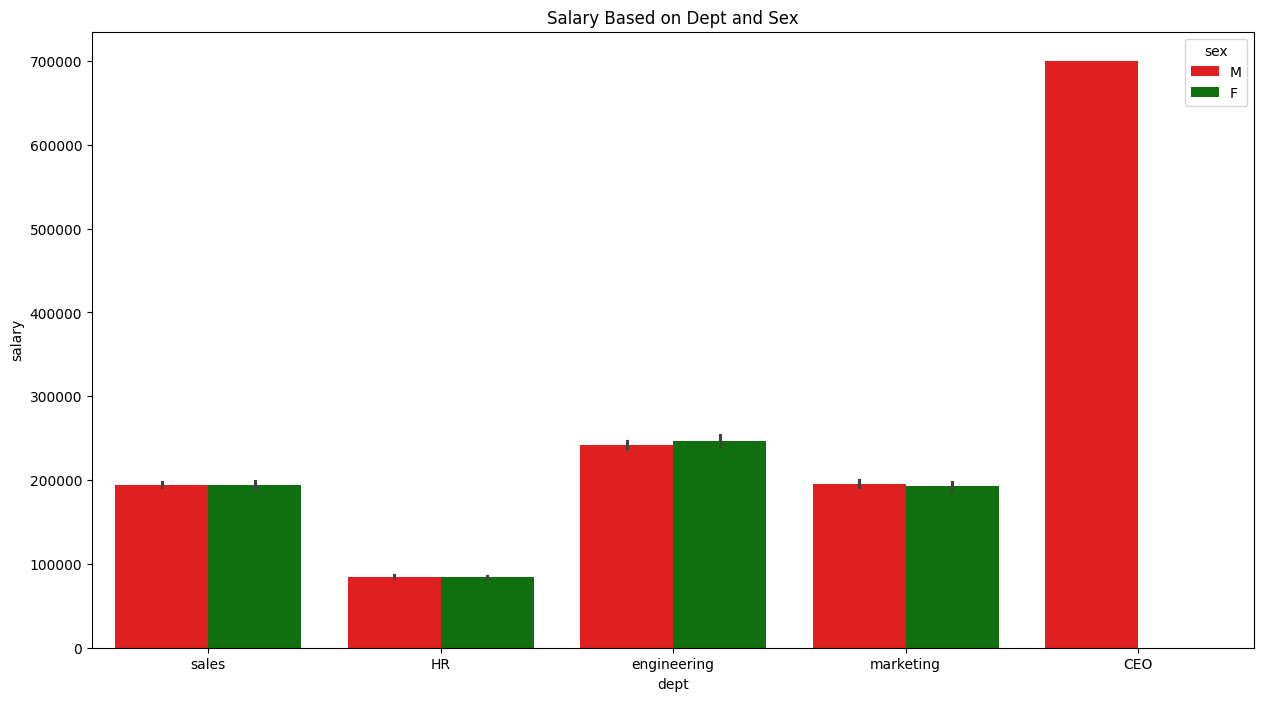

In [30]:
#graph looking at salary, sex, and dept

plt.figure(figsize=(15,8))
plt.title("Salary Based on Dept and Sex")
sns.barplot(x='dept', y='salary', hue='sex', data=df, palette=color_palette)

In [ ]:
def remove_outliers_iqr(df, factor=1.0):
    # Select only numeric columns for outlier removal
    numeric_df = df.select_dtypes(include=[float, int])
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for each numeric feature
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    
    # Calculate IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the rows where the data is outside the bounds (only for numeric columns)
    df_no_outliers = df[~((numeric_df < lower_bound)   | (numeric_df > upper_bound)).any(axis=1)]
    
    return df_no_outliers

# Remove outliers from the entire DataFrame (including 'salary', which should be numeric)
df_no = remove_outliers_iqr(df, factor=2.0)

# Check the shape of the data before and after removing outliers
print(f"Original shape: {df.shape}")
print(f"Shape after removing outliers: {df_no.shape}")

Original shape: (10000, 10)
Shape after removing outliers: (9000, 10)


C:\Users\brean\AppData\Local\Temp\ipykernel_7964\4110721515.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(x='dept', y='salary', hue='sex', data=df_no, palette=color_palette)


<Axes: title={'center': 'Salary Based on Dept and Sex'}, xlabel='dept', ylabel='salary'>

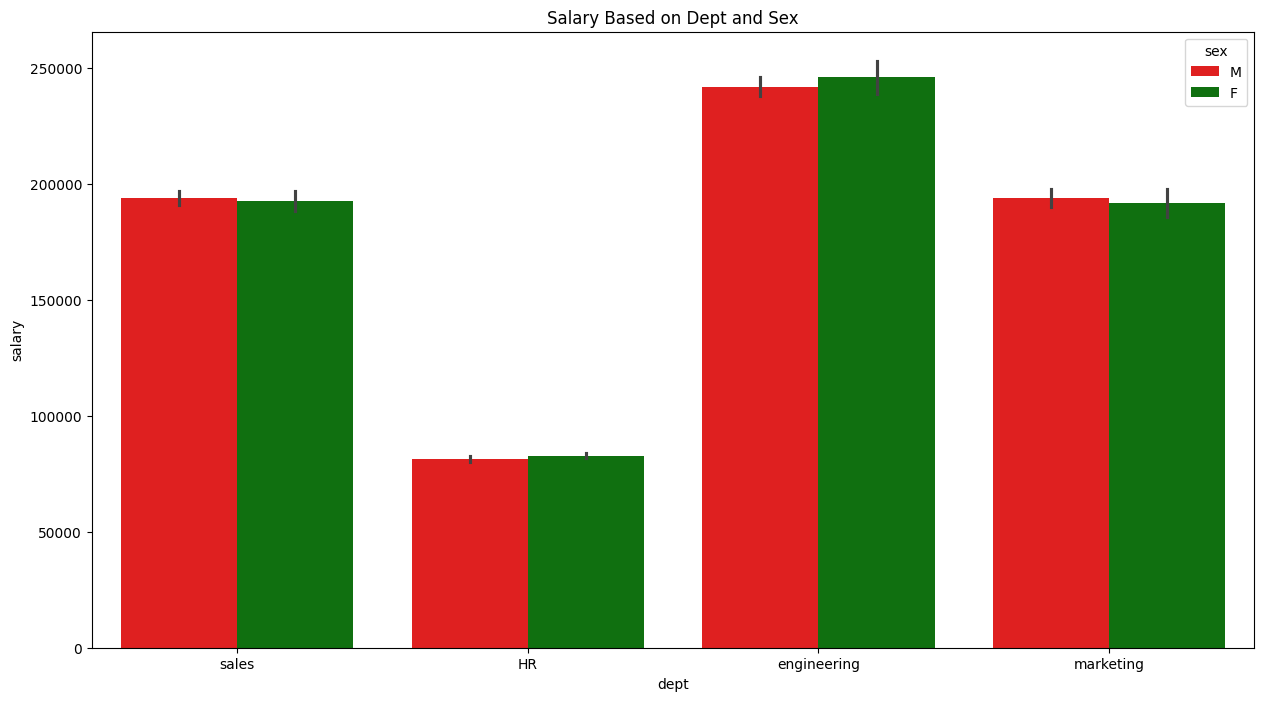

In [108]:
#graph looking at salary, sex, and dept

plt.figure(figsize=(15,8))
plt.title("Salary Based on Dept and Sex")
sns.barplot(x='dept', y='salary', hue='sex', data=df_no, palette=color_palette)

From this graph we see that females make roughly the same amount as males, generally. There is a slight increase in engineering and a slight decrease in marketing, but this graph doesn't compare years of service. 

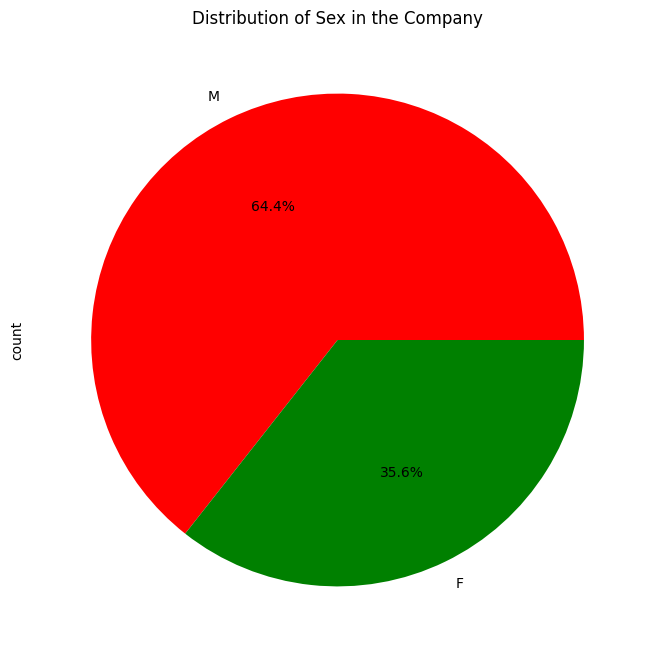

In [31]:
# Count the number of females versus males
counts = df['sex'].value_counts()

# Create the pie chart
plt.figure(figsize=(15,8))
plt.title("Distribution of Sex in the Company")
counts.plot.pie(autopct='%1.1f%%', colors= color_palette)
plt.show()

From this pie chart we can clearly see that there are many more males versus femaels in the company overall

C:\Users\brean\AppData\Local\Temp\ipykernel_7964\3397658462.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.violinplot(x ="degree_level", y ="salary", data = df, hue = 'sex', palette=color_palette)


<Axes: title={'center': 'Salary based on education level and sex'}, xlabel='degree_level', ylabel='salary'>

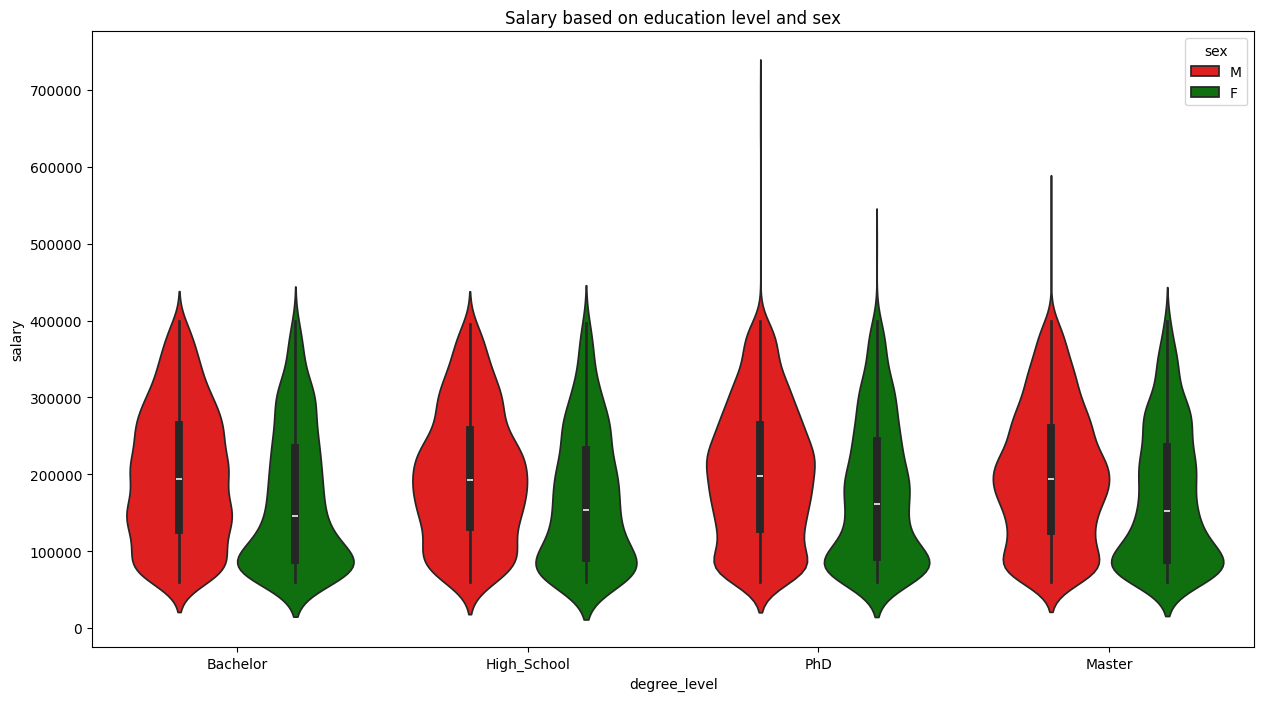

In [32]:
plt.figure(figsize=(15,8))
plt.title("Salary based on education level and sex")
sns.violinplot(x ="degree_level", y ="salary", data = df, hue = 'sex', palette=color_palette)

C:\Users\brean\AppData\Local\Temp\ipykernel_7964\2665475440.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.violinplot(x ="degree_level", y ="salary", data = df_no, hue = 'sex', palette=color_palette)


<Axes: title={'center': 'Salary based on education level and sex'}, xlabel='degree_level', ylabel='salary'>

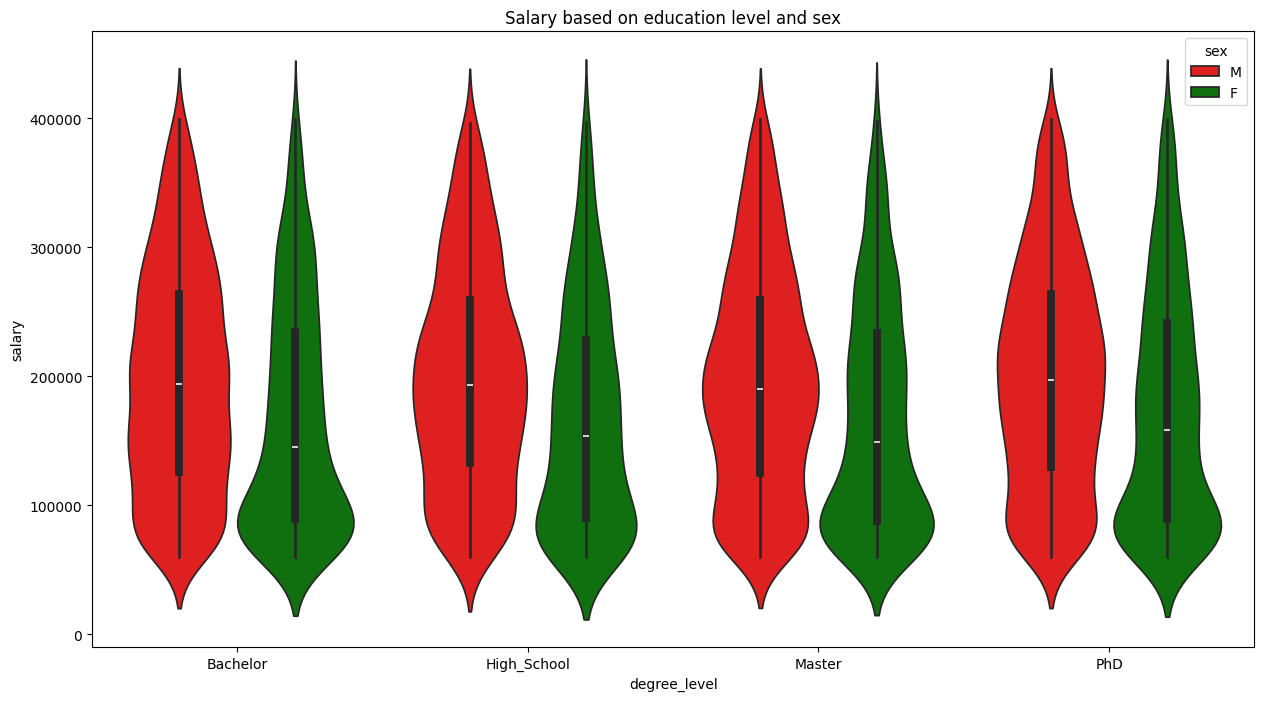

In [109]:
plt.figure(figsize=(15,8))
plt.title("Salary based on education level and sex")
sns.violinplot(x ="degree_level", y ="salary", data = df_no, hue = 'sex', palette=color_palette)

according to this graph, women with the same degree as men, are getting paid less, but this still doesn't take into account the department or years of experience

C:\Users\brean\AppData\Local\Temp\ipykernel_7964\1665163803.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x='yrs_experience', y='salary', hue='sex', data=df_no, palette=color_palette)


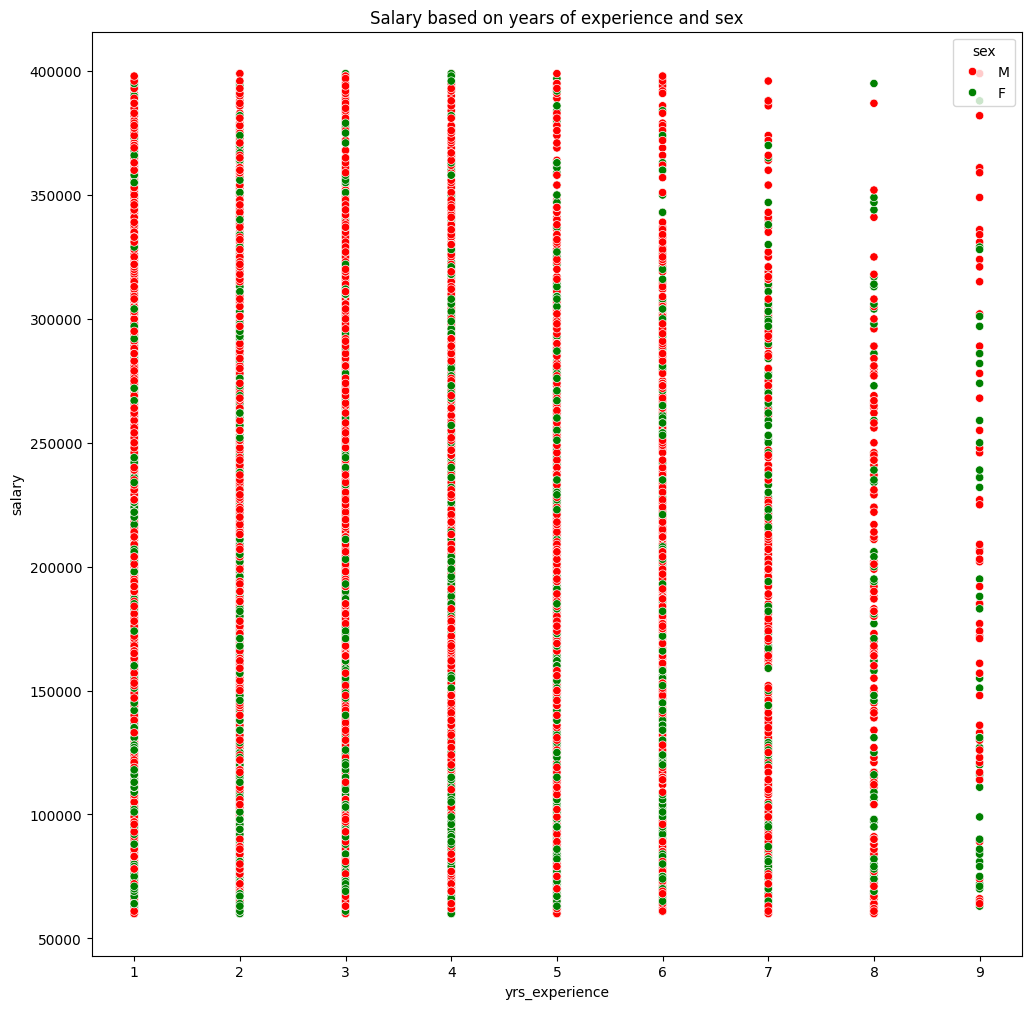

In [110]:
plt.figure(figsize=(12,12))
sns.scatterplot(x='yrs_experience', y='salary', hue='sex', data=df_no, palette=color_palette)
plt.title("Salary based on years of experience and sex")
plt.show()

C:\Users\brean\AppData\Local\Temp\ipykernel_7964\3535239743.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.violinplot(x ="yrs_experience", y ="salary", data = df_no, hue = 'sex', palette=color_palette)


<Axes: title={'center': 'Salary based on education level and sex'}, xlabel='yrs_experience', ylabel='salary'>

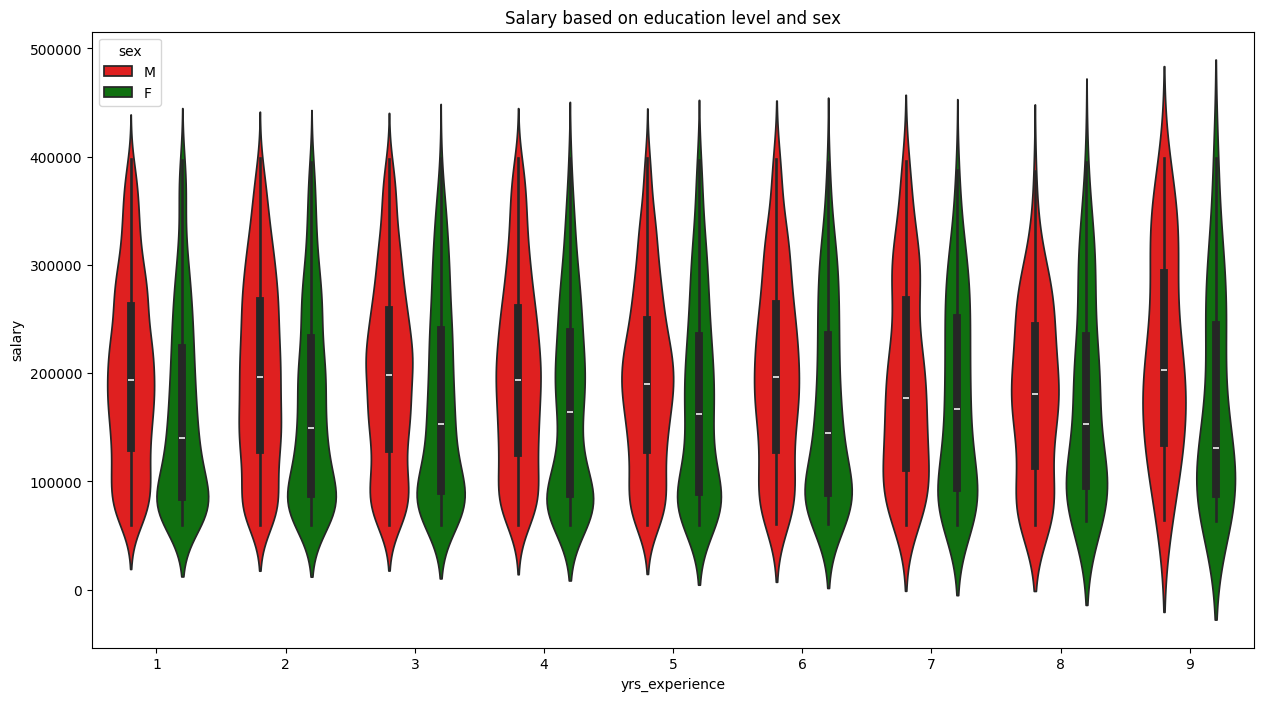

In [111]:
plt.figure(figsize=(15,8))
plt.title("Salary based on education level and sex")
sns.violinplot(x ="yrs_experience", y ="salary", data = df_no, hue = 'sex', palette=color_palette)

This graph does appear to show that males are paid more than women, when compared to experience levels so we'll need to look into this further

In [ ]:
#making a copy for changes
df2 = df.copy()

In [92]:
print(df2['dept'].unique())

['sales' 'HR' 'engineering' 'marketing' 'CEO']


In [93]:
# Define mapping dictionaries
degree_mapping = {"High_School": 1, "Bachelor": 2, "Master": 3, "PhD": 4}
level_mapping = {"IC": 1, "MM": 2, "D": 3, "VP": 4, "E": 5, "CEO": 6}
dept_mapping = {"sales": 1, "HR": 2, "engineering": 3, "marketing": 4, "CEO": 5}

In [94]:
# Apply mappings using .replace() and explicitly cast to integer after applying `infer_objects()`
df2['degree_level'] = df2['degree_level'].replace(degree_mapping).infer_objects().astype(int)
df2['level'] = df2['level'].replace(level_mapping).infer_objects().astype(int)
df2['dept'] = df2['dept'].replace(dept_mapping).infer_objects().astype(int)

C:\Users\brean\AppData\Local\Temp\ipykernel_7964\2782774932.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['degree_level'] = df2['degree_level'].replace(degree_mapping).infer_objects().astype(int)
C:\Users\brean\AppData\Local\Temp\ipykernel_7964\2782774932.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['level'] = df2['level'].replace(level_mapping).infer_objects().astype(int)
C:\Users\brean\AppData\Local\Temp\ipykernel_7964\2782774932.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will b

In [95]:
# Convert 'sex' to a numerical feature using np.where
df2['sex'] = (df2['sex'] == 'M').astype(int) 

# Display the first few rows of the modified DataFrame
print(df2.head())

   employee_id   boss_id  dept  signing_bonus    salary  degree_level  sex  \
0        46456  175361.0     1              0  213000.0             2    1   
1       104708   29733.0     2              0   79000.0             2    0   
2       120853   41991.0     1              0  199000.0             1    1   
3       142630  171266.0     2              0  143000.0             4    0   
4        72711  198240.0     1              0  235000.0             3    1   

   yrs_experience  level  total_reports  
0               5      1              0  
1               3      1              0  
2               5      1              0  
3              13      2             16  
4               1      1              0  


In [96]:
df.head()

,employee_id,boss_id,dept,signing_bonus,salary,degree_level,sex,yrs_experience,level,total_reports
0,46456,175361.0,sales,0,213000.0,Bachelor,M,5,IC,0
1,104708,29733.0,HR,0,79000.0,Bachelor,F,3,IC,0
2,120853,41991.0,sales,0,199000.0,High_School,M,5,IC,0
3,142630,171266.0,HR,0,143000.0,PhD,F,13,MM,16
4,72711,198240.0,sales,0,235000.0,Master,M,1,IC,0


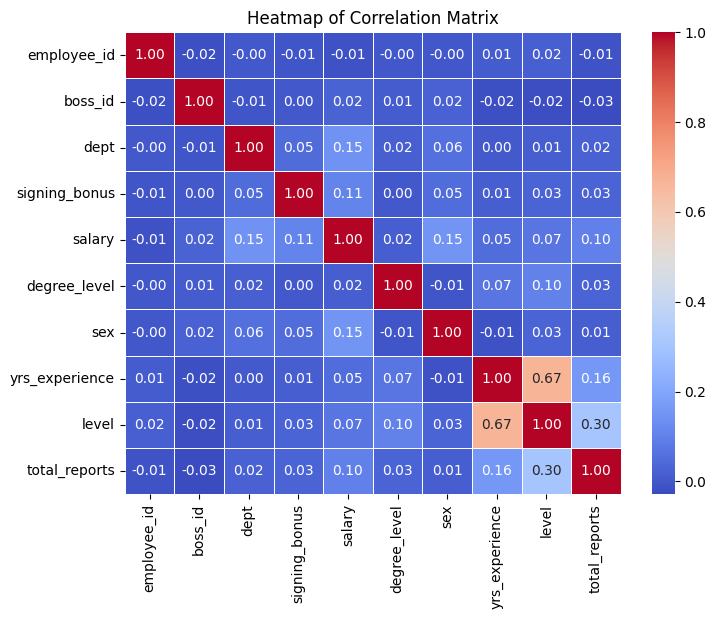

In [97]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the plot
plt.title('Heatmap of Correlation Matrix')
plt.show()

created a heatmap to see if there are any obvious correlations between the salary and the other factors but there does appear to be a correlation between years of experience and their level so that does make sense. 

C:\Users\brean\AppData\Local\Temp\ipykernel_7964\3238942470.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['degree_level'] = df2['degree_level'].replace(degree_mapping).infer_objects().astype(int)
C:\Users\brean\AppData\Local\Temp\ipykernel_7964\3238942470.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['level'] = df2['level'].replace(level_mapping).infer_objects().astype(int)
C:\Users\brean\AppData\Local\Temp\ipykernel_7964\3238942470.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will 

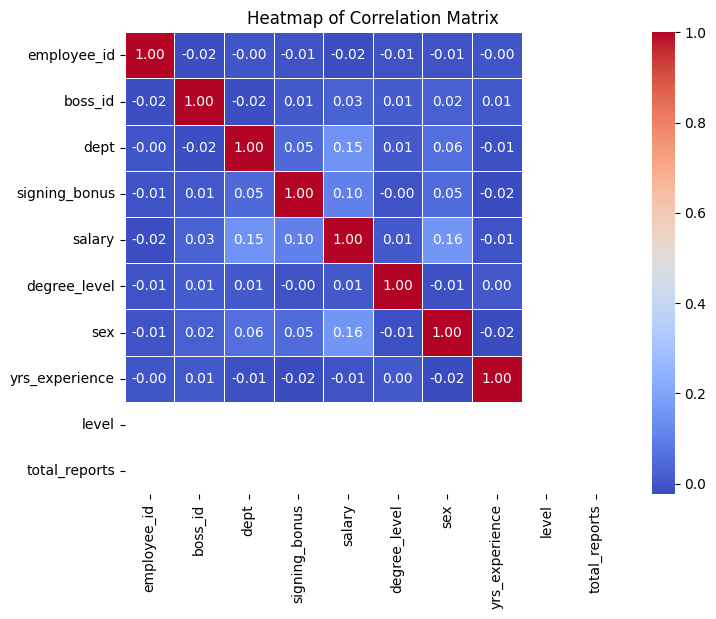

In [113]:
#making a copy for changes
df2 = df_no.copy()
# Define mapping dictionaries
degree_mapping = {"High_School": 1, "Bachelor": 2, "Master": 3, "PhD": 4}
level_mapping = {"IC": 1, "MM": 2, "D": 3, "VP": 4, "E": 5, "CEO": 6}
dept_mapping = {"sales": 1, "HR": 2, "engineering": 3, "marketing": 4, "CEO": 5}
# Apply mappings using .replace() and explicitly cast to integer after applying `infer_objects()`
df2['degree_level'] = df2['degree_level'].replace(degree_mapping).infer_objects().astype(int)
df2['level'] = df2['level'].replace(level_mapping).infer_objects().astype(int)
df2['dept'] = df2['dept'].replace(dept_mapping).infer_objects().astype(int)
# Convert 'sex' to a numerical feature using np.where
df2['sex'] = (df2['sex'] == 'M').astype(int) 
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the plot
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [114]:
#fill in nan value for following testing
df2['boss_id'] = df2['boss_id'].fillna(0)

In [115]:
# Step 5: Split data into features and target
x2 = df2.drop(columns=['salary'])  # Features (drop the target column 'salary')
y2 = df2['salary']  # Target variable

In [116]:
# scale features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x2)

In [117]:
# Apply feature selection using f_regression
selector = SelectKBest(f_regression, k=5)
selector.fit(x_scaled, y2)

SelectKBest(k=5, score_func=<function f_regression at 0x00000229BB8D7880>)

In [118]:
# print most 
selected_columns = x2.columns[selector.get_support(indices=True)]
# print(f"Important features: {selected_columns}")

In [119]:
scores = selector.scores_

In [120]:
top_5_features = sorted(zip(scores, selected_columns), reverse=True)[:5]

print("Top 5 features based on SelectKBest (f_regression):")
for score, feature in top_5_features:
    print(f"Feature: {feature}, Score: {score}")

Top 5 features based on SelectKBest (f_regression):
Feature: dept, Score: 196.82473894001626
Feature: signing_bonus, Score: 95.25347317283737
Feature: boss_id, Score: 8.202589859382373
Feature: employee_id, Score: 2.6201870298627696
Feature: sex, Score: 0.6435449979398058


In [89]:
top_5_features = sorted(zip(scores, selected_columns), reverse=True)[:5]

print("Top 5 features based on SelectKBest (f_regression):")
for score, feature in top_5_features:
    print(f"Feature: {feature}, Score: {score}")

Top 5 features based on SelectKBest (f_regression):
Feature: yrs_experience, Score: 221.81977667526158
Feature: level, Score: 112.90110662785641
Feature: signing_bonus, Score: 6.0679020689513985
Feature: total_reports, Score: 2.2836997786983524
Feature: dept, Score: 2.2170828739387796


of all of the columns given, these ones are the most influential on your salary. years of experience is number one, level within the company is number two, your signing bonus is number three, total reports (the number of people you're in charge of) is number four, and your department is number five. This code specifically looks at all deptartments that were given a numerical value. 

In [121]:
#fill in nan value for following testing
df_no['boss_id'] = df_no['boss_id'].fillna(0)

C:\Users\brean\AppData\Local\Temp\ipykernel_7964\892173162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no['boss_id'] = df_no['boss_id'].fillna(0)


In [122]:
# Step 1: Identify numeric and categorical columns
numeric_columns = df_no.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = df_no.select_dtypes(include=['object']).columns.tolist()


In [123]:
# Remove the target column 'salary' from the features
numeric_columns.remove('salary')  # Remove 'salary' from numeric columns

In [124]:
# Step 2: Define the preprocessing pipeline (excluding 'salary')
preprocessor = ColumnTransformer(
    transformers=[
        # Apply StandardScaler to numeric columns
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', StandardScaler())  # Scale numeric features
        ]), numeric_columns),
        
        # Apply OneHotEncoder to categorical columns
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
            ('onehot', OneHotEncoder(drop='first'))  # One-hot encode categorical features
        ]), categorical_columns)
    ])

In [125]:
# Step 3: Apply SelectKBest for feature selection
select_k_best = SelectKBest(score_func=f_regression, k=5)  # Select top 5 features based on f_regression

In [126]:
print(select_k_best)

SelectKBest(k=5, score_func=<function f_regression at 0x00000229BB8D7880>)


In [127]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=5))  # Apply feature selection after preprocessing
])

In [128]:
df.head()

,employee_id,boss_id,dept,signing_bonus,salary,degree_level,sex,yrs_experience,level,total_reports
0,46456,175361.0,sales,0,213000.0,Bachelor,M,5,IC,0
1,104708,29733.0,HR,0,79000.0,Bachelor,F,3,IC,0
2,120853,41991.0,sales,0,199000.0,High_School,M,5,IC,0
3,142630,171266.0,HR,0,143000.0,PhD,F,13,MM,16
4,72711,198240.0,sales,0,235000.0,Master,M,1,IC,0


In [129]:
# Step 5: Split data into features and target
x = df_no.drop(columns=['salary'])  # Features (drop the target column 'salary')
y = df_no['salary']  # Target variable

In [130]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [131]:
# Step 1: Fit the pipeline on the training data
pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employee_id', 'boss_id',
                                                   'signing_bonus',
                                                   'yrs_experience',
                                                   'total_reports']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'degree_level',
                                                   'sex', 'level'])])),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x00000229BB8D7880>))])

In [132]:
# Step 2: Extract the SelectKBest step from the pipeline
feature_selection = pipeline.named_steps['feature_selection']

In [133]:
# Step 3: Get the feature scores from SelectKBest
feature_scores = feature_selection.scores_

In [134]:
# Step 4: Get the mask of selected features (True for selected)
selected_features_mask = feature_selection.get_support()

In [135]:
# (Note: You may need to adjust this according to your actual feature set)
onehot_columns = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_columns)

In [136]:
# Combine the column names (numeric columns + one-hot encoded categorical columns)
all_feature_names = np.concatenate([numeric_columns, onehot_columns])

In [137]:
# Step 6: Get the names of the selected features based on the mask
selected_feature_names = all_feature_names[selected_features_mask]

In [138]:
# Step 7: Sort the selected features by their score
top_5_features = sorted(zip(feature_scores, selected_feature_names), reverse=True)[:5]

# Step 8: Print the top 5 features with their scores
print("Top 5 features based on SelectKBest:")
for score, feature in top_5_features:
    print(f"Feature: {feature}, Score: {score}")

Top 5 features based on SelectKBest:
Feature: dept_engineering, Score: 76.01613726004638
Feature: signing_bonus, Score: 10.858603196578368
Feature: boss_id, Score: 2.175578393839519
Feature: dept_sales, Score: 0.3023107024931546
Feature: sex_M, Score: 0.0


In [76]:
# Step 7: Sort the selected features by their score
top_5_features = sorted(zip(feature_scores, selected_feature_names), reverse=True)[:5]

# Step 8: Print the top 5 features with their scores
print("Top 5 features based on SelectKBest:")
for score, feature in top_5_features:
    print(f"Feature: {feature}, Score: {score}")

Top 5 features based on SelectKBest:
Feature: dept_HR, Score: 97.2434458880282
Feature: sex_M, Score: 67.33017306002701
Feature: dept_engineering, Score: 26.71437631393151
Feature: total_reports, Score: 3.7754074936609867
Feature: signing_bonus, Score: 2.120725951859364


What we did in this code is set up one hot encoders for each categorical column. Meaning that the level column would turn into five individual columns since there are five options and an employee would be labeled a 0 or 1 based on which option they had in the original column. By doing this, we increased our number of columns and the top five features is now based on all of these newly created columns. Because of this, we have more in depth information on what specifically affects someone's salary. So, if someone is in the HR department (though this results in a lower salary; it still has a huge affect), if someone is male (we did also see in the graphs that this did cause a salary increase), if someone is in the engineering dept (which would cause a significant increase in salary), someone's total reports (the total number of people who they're in charge of), and their signing bonus. 

In [98]:
# Step 6: Fit and transform the training data
x_train_transformed = pipeline.fit_transform(x_train, y_train)

In [99]:
# Apply the same transformations to the test data
x_test_transformed = pipeline.transform(x_test)

In [100]:
model = LinearRegression()
model.fit(x_train_transformed, y_train)

LinearRegression()

In [101]:
# Step 8: Make predictions and evaluate the model
y_pred = model.predict(x_test_transformed)

In [102]:
# Evaluate the model (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Accuracy: MAE={mae}, MSE={mse}, RMSE={rmse}, MAPE={mape}%")

Accuracy: MAE=57143.59975542478, MSE=5254551408.132203, RMSE=72488.28462677402, MAPE=36.94381821624806%


In [ ]:
# Predict salary for a new employee
new_employee = pd.DataFrame({
    'department': ['IT'],
    'years_of_experience': [6],
    'education_level': ['Master\'s'],
    'gender': ['Male'],
    'age': [32]
})

predicted_salary = model_pipeline.predict(new_employee)
print(f'Predicted Salary for new employee: {predicted_salary[0]}')